## **Lab 2: k-Nearest Neighbour**

CS 412

***This lab is for group work.***

In this lab, we will see how to implement and use k-Nearest Neighbour for classification tasks _step by step_.

***Deadline:***
**5 PM, Monday of Week 5 (Feb 6)**.


## <font color='red'> Please refer to `Lab_Guideline.pdf` in the same Google Drive folder as this Jupyter notebook; the guidelines there apply to all the labs.</font>

## Problem 1: Implementation of the k-Nearest Neighbours (kNN) classifier **(65 points)**

In Problem 1, you will implement kNN from scratch, which is a good exercise to make sure that you fully understand the algorithm.
Do not use any library such as scikit-learn that already has kNN implemented.
But you can use general libraries for array and matrix operations such as numpy.


**Step 1. (20 points)** The kNN classifier mainly consists of two stages:

1.   During training, the classifier takes the training data and simply stores it.
2.   During testing, kNN classifies every test example $x$ by 

> i) finding the $k$ training examples that are most similar to $x$;

> ii) outputing the most common label among these $k$ examples.

To measure the similarity between samples, we commonly compute the Euclidean distance. The Euclidean distance (a.k.a. $L_2$ distance) between two examples $p$ and $q$ in an $n$-dimensional space is defined as the square root of:

\begin{equation}
(p_1-q_1)^2 + (p_2-q_2)^2 + ... + (p_n-q_n)^2. \tag{1}
\end{equation}

This term is equal to 
\begin{equation}
\sum_i p_i^2 + \sum_i q_i^2 - 2 \sum_i p_i q_i. \tag{2}
\end{equation}


With Euclidean distance, the smaller the value, the more similar the two examples are. Actually, there are many different ways to measure the similarity, such as cosine distance, Manhattan, Chebyshev, and Hamming distance. In practice, you can choose the one that suits your problem. For this lab, we will implement Equation (2) with a function `my_euclidean_dist` that  computes the Euclidean distances.

**DO NOT use np.linalg.norm() or function from scipy.**  Make sure your implementation is generic, i.e., not hard coding the number of feature to 2, or the number of training example to 10.

**Unit test:** to unit test `my_euclidean_dist`, you can construct two matrices by yourself, e.g., `X_train` being 3-by-2 and `X_test` being 2-by-2. Then you can compute the squared Euclidean distances by hand, and compare it with the result of your code.  See the last four lines of the following code block, which lie outside the definition of `my_euclidean_dist`.  You can uncomment them for testing, but comment them back when you finish the entire lab.

`euclidean_dist` will be called eventually by the `knn_predict` function in Step 3 below.

In [106]:
# set up code for this experiment
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1)


In [107]:
def my_euclidean_dist(X_test, X_train):
  """
  Compute the *squared* distance between each test example and each training example

  Input:
  - X_test: A numpy array of shape (num_test, dim_feat) containing test data
  - X_train: A numpy array of shape (num_train, dim_feat) containing training data

  Output:
  - dists: A numpy array of shape (num_test, num_train) where 
           dist[i, j] is the squared Euclidean distance between 
           the i-th test example and the j-th training example
  """
  num_test = X_test.shape[0]
  num_train = X_train.shape[0]
  dists = np.zeros((num_test, num_train))
  # TODO:
  # Compute the squared L2 distance between all test and training examples.
  #
  # One most straightforward way is to use nested for loop
  # to iterate over all test and training samples.
  # Here is the pseudo-code:
  # for i = 0 ... num_test - 1
  #    a[i] = square of the norm of the i-th test example
  # for j = 0 ... num_train - 1
  #    b[j] = square of the norm of the j-th training example
  # for i = 0 ... num_test - 1
  #    for j = 0 ... num_train - 1
  #        dists[i, j] = a[i] + b[j] - 2 * np.dot(i-th test example, j-th training example)
  # return dists
  
  
  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

  # calculate square of the norm of the i-th test example
  for i in range(num_test):
    a = sum(np.square(X_test[i]))
    # calculate square of the norm of the i-th train example
    for j in range(num_train):
      b = sum(np.square(X_train[j]))
      # calculate distance for i-th test example & i-th train example
      dists[i,j] = a + b - 2* np.dot(X_test[i], X_train[j])

  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)***** 

  return dists

# Unit test code here (you can uncomment the four lines below to test)
# Compute by hand to check if the result is correct.
# The right matrix of squared distance should be
# [[ 8 10  1]
#  [ 2  8  9]]
X_train = np.array([[1, 2], [0, 3], [-1, 1]])
X_test = np.array([[-1, 0], [2, 1]])
my_dists = my_euclidean_dist(X_test, X_train)
print(my_dists)

[[ 8. 10.  1.]
 [ 2.  8.  9.]]


However, you can entirely avoid using loops by reformulating Equation (2) with linear algebra.  The trick is to reformulate the L2 distance as two broadcast sums and matrix multiplication.  

**Task:** Try the following implementation and feel the speedup!  Understand the following implementation.  You do not need to write down your understanding or submit anything for it, but it will be helpful to understand it.

**Note:**  Since Euclidean distance computation underlies all the subsequent experiments, its efficiency is highly important. Therefore, in the sequel, we will NOT use `my_euclidean_dist` that you just implemented.  Instead, we will use `euclidean_dist`.  However, your implementation of `my_euclidean_dist` will still be graded based on unit test; it will need to be copied to `Lab_1.py` (see submission instruction at the bottom of the page).

In [108]:
def euclidean_dist(X_test, X_train):
  dists = np.add(np.sum(X_test ** 2, axis=1, keepdims=True), np.sum(X_train ** 2, axis=1, keepdims=True).T) - 2* X_test @ X_train.T
  return dists

# Unit test code here (you can uncomment the four lines below to test)
X_train = np.array([[1, 2], [0, 3], [-1, 1]])
X_test = np.array([[-1, 0], [2, 1]])
dists = euclidean_dist(X_test, X_train)
print(dists)

[[ 8 10  1]
 [ 2  8  9]]


**Step 2. (20 points)**  Once distances are calculated, we can find the top $k$ nearest neighbors for each test example by retrieving from the dists matrix. 
In particular, for each test example $x$, we can sort all the training examples by their distance to $x$ then find the $k$ most nearest neighbors.  

**HINT**: Recall from the lecture that `argsort` is useful for this purpose.

**Note**: to run the unit test, you need to uncomment the unit test in the previous code block.

In [109]:
def find_k_neighbors(dists, Y_train, k):
  """
  find the labels of the top k nearest neighbors

  Inputs:
  - dists: distance matrix of shape (num_test, num_train)
  - Y_train: A numpy array of shape (num_train) containing ground truth labels for training data
  - k: An integer, k nearest neighbors

  Output:
  - neighbors: A numpy array of shape (num_test, k), where each row containts the 
               labels of the k nearest neighbors for each test example
  """
  # TODO:
  # find the top k nearest neighbors for each test sample.
  # retrieve the corresponding labels of those neighbors.
  # Here is the pseudo-code:
  # for i = 0 ... num_test-1
  #     idx = numpy.argsort(i-th row of dists)
  #     neighbors[i] = Y_train(idx[0]), ..., Y_train(idx[k-1])
  # return neighbors
  # Advanced: You can accelerate the code by, e.g., argsort on the `dists` matrix directly

  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  num_test = dists.shape[0]
  neighbors = np.zeros((num_test, k))
  # sort indices of dists by shortest to longest distance
  idx = np.argsort(dists, axis=1)
  
  # return label for k closest neighbors
  for i in range(num_test):
    for j in range(k):
      neighbors[i][j] = Y_train[idx[i][j]]
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return neighbors

# Unit test code here (you can uncomment the lines below to test)
# Compute by hand to check if the result is correct.
"""
[[1. 0. 1.]
 [0. 1. 1.]]
"""
k = 3   # you can vary it as 1 or 3
Y_train = np.array([0, 1, 1])
neighbors = find_k_neighbors(dists, Y_train, k)
print(neighbors)

[[1. 0. 1.]
 [0. 1. 1.]]


**Step 3. (20 points)** Finally, we can put together `euclidean_dist` and `find_k_neighbors`, so that labels can be predicted for test examples.  In kNN, we take the labels of the $k$ nearest neighbors and find the most common one and assign it to the test sample.

**Hint:** You may find [`np.unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html#numpy-unique) and `argmax` useful.

In [110]:
def knn_predict(X_test, X_train, Y_train, k):
  """
  predict labels for test data.

  Inputs:
  - X_test: A numpy array of shape (num_test, dim_feat) containing test data.
  - X_train: A numpy array of shape (num_train, dim_feat) containing training data.
  - Y_train: A numpy array of shape (num_train) containing ground truth labels for training data
  - k: An integer, k nearest neighbors

  Output:
  - Y_pred: A numpy array of shape (num_test). Predicted labels for the test data.
  """
  # TODO:
  # find the labels of k nearest neighbors for each test example,
  # and then find the majority label out of the k labels
  #
  # Here is the pseudo-code:
  # dists = euclidean_dist(X_test, X_train)
  # neighbors = find_k_neighbors(dists, Y_train, k)
  # Y_pred = np.zeros(num_test, dtype=int)  # force dtype=int in case the dataset
  #                                         # stores labels as float-point numbers
  # for i = 0 ... num_test-1
  #     Y_pred[i] = # the most common/frequent label in neighbors[i], you can
  #                 # implement it by using np.unique
  # return Y_pred

  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  # find euclidean distance of x_test vals to x_train vals
  dists = euclidean_dist(X_test, X_train)
  # return the labels of the k nearest training vals
  neighbors = find_k_neighbors(dists, Y_train, k)
  
  # calculate num_test
  num_test = X_test.shape[0]
  # initialize empty array for Y_pred of length num_test
  Y_pred = np.zeros(num_test, dtype=int)
  
  # calculate most frequent label in neigbors add to Y_pred
  for i in range(num_test):
    labels, counts = np.unique(neighbors[i], return_counts=True)
    Y_pred[i] = labels[np.argmax(counts)]
  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return Y_pred

# Unit test code here (you can uncomment the lines below to test)
# Compute by hand to check if the result is correct.
"""
[1 1]
"""
Y_pred = knn_predict(X_test, X_train, Y_train, k)
print(Y_pred)

[1 1]


**Step 4. (5 points)** Once we obtain the predicted labels, we need to implement a function to compare them against the true label and compute the error rate in percentage (i.e., a number between 0 and 100). In the following code block, implement the `compute_error_rate` function by following the specified inputs and output.

In [111]:
def compute_error_rate(ypred, ytrue):
  """
  Compute error rate given the predicted results and true label.
  Inputs:
  - ypred: array of prediction results.
  - ytrue: array of true labels.
    ypred and ytrue should be of same length.
  Output:
  - error rate: float number indicating the error in percentage
                (i.e., a number between 0 and 100).
  """
  # Here is the pseudo-code:
  # err = 0
  # for i = 0 ... num_test - 1
  #     err = err + (ypred[i] != ytrue[i])  # generalizes to multiple classes
  # error_rate = err / num_test * 100
  # return error_rate
  #
  # Advanced (optional): 
  #   implement it in one line by using vector operation and the `mean` function

  # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  num_test = ypred.shape[0]
  err = 0
  for i in range(num_test):
    err = err + (ypred[i] != ytrue[i])

  error_rate = err / num_test * 100


  # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  return error_rate

ypred = np.array([1,0,0,1,0])
ytrue = np.array([1,0,0,1,1])

compute_error_rate(ypred, ytrue)



20.0

## Problem 2: Optical character recognition (OCR) **(35 points)**{-}

We will now apply the above developed function to a real world problem of optical character recognition (OCR).

**Load the MNIST dataset.** In the following code block, we have downloaded the MNIST dataset and split the data into trainning and test sets. This part has already been done, and you can directly run it with no need of modifying the code.  But do make sure that you understand the code as it will be useful for future labs.

**Note:** after running the code, the training data (Xtrain, ytrain) has 10,000 examples, and the test data (Xtest, ytest) also has 10,000 examples.

In [112]:
import os
import gzip

DATA_URL = ' http://www.cs.uic.edu/~zhangx/teaching/'

# Download and import the MNIST dataset from Yann LeCun's website.
# Each image is an array of 784 (28x28) float values  from 0 (white) to 1 (black).
def load_data():
    x_tr = load_images('train-images-idx3-ubyte.gz')
    y_tr = load_labels('train-labels-idx1-ubyte.gz')
    x_te = load_images('t10k-images-idx3-ubyte.gz')
    y_te = load_labels('t10k-labels-idx1-ubyte.gz')

    return x_tr, y_tr, x_te, y_te

def load_images(filename):
    maybe_download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28 * 28) / np.float32(256)

def load_labels(filename):
    maybe_download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

# Download the file, unless it's already here.
def maybe_download(filename):
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        print("Downloading %s" % filename)
        urlretrieve(DATA_URL + filename, filename)

Xtrain, ytrain, Xtest, ytest = load_data()

train_size = 10000
test_size  = 10000

Xtrain = Xtrain[0:train_size]
ytrain = ytrain[0:train_size]

Xtest = Xtest[0:test_size]
ytest = ytest[0:test_size]



## 2.1 Effect of different numbers of training examples

**(35 points)** In the following code block, we will compute the classification error of the 1-NN ($k=1$) for the MNIST dataset by calling the `knn_predict` function. We will study does the error change with different number of training examples.

**Tasks**: train on the **first** $ntr$ number of training examples in (Xtrain, ytrain) that is produced by the above data-loading code, where $ntr$ is varied in $\{100, 1000, 2500, 5000, 7500, 10000\}$.
1. Print the test error rate for each of these values of $ntr$.  Note that the above data-loading code produces 10,000 test examples stored in (Xtest, ytest). Just use all of them for testing, i.e., fixing the test set size to 10000.
2. Plot a figure where the $x$-axis is the above values of $ntr$, and the $y$-axis is the test error rate.

Directly calling `knn_predict` with the training and test set may cost too much memory.  So we will classify the test examples in batches, i.e., divide the test set into `nbtaches` number of subsets/batches, and predict for the first batch, then second batch, etc. For example, with 30 test examples and 5 batches, we first use `knn_predict` to classify test examples 0...5, then 6...11, ..., and finally 26...29.

**Hint:** you may refer [here](https://matplotlib.org/tutorials/introductory/pyplot.html) for how to plot in python.

trial size =  100 error rate =  32.06 %
trial size =  1000 error rate =  13.100000000000001 %
trial size =  2500 error rate =  8.64 %
trial size =  5000 error rate =  6.569999999999999 %
trial size =  7500 error rate =  5.91 %
trial size =  10000 error rate =  5.37 %


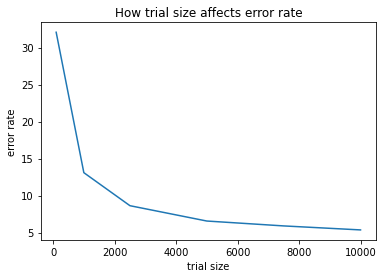

In [117]:
#  nbatches must be an even divisor of test_size. Increase if you run out of memory 
if test_size > 1000:
  nbatches = 50
else:
  nbatches = 5

# Let us first set up the index of each batch. 
# After running the next line, 'batches' will be a 2D array sized nbatches-by-m,
# where m = test_size / nbatches.
# batches[i] stores the indices (out of 0...test_size-1) for the i-th batch
# You can run 'print(batches[3])' etc to witness the value of 'batches'.
batches = np.array_split(np.arange(test_size), nbatches)
ypred = np.zeros_like(ytest)
trial_sizes = [100, 1000, 2500, 5000, 7500, 10000]
trials = len(trial_sizes)
error_rates = [0]*trials
k = 1

# Here is the pseudo code:
# 
# for t = 0 ... trials-1  # loop over different number of training examples
# 	trial_size = trial_sizes[t]
# 	trial_X = Xtrain[...] # extract trial_size number of training examples from the whole training set
# 	trial_Y = Ytrain[...] # extract the corresponding labels
# 	for i = 0…nbatches—1
# 		ypred[...] = # call knn_predict to classify the i-th batch of test examples.
#                  # You should use 'batches' to get the indices for batch i.
#                  # Then store the predicted labels also in the corresponding
#                  # elements of ypred, so that after the loop over i completes,
#                  # ypred will hold exactly the predicted labels of all test examples.
# 	error_rates[t] = # call compute_error_rate to compute the error rate by 
#                     comparing ypred against ytest
#   print a line like '#tr = 100, error rate = 50.3%'
# plot the figure:
# f = plt.figure()
# plt.plot(...)
# plt.xlabel(...)
# plt.ylabel(...)
# plt.show()


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for t in range(trials):
  trial_size = trial_sizes[t]
  trial_X = Xtrain[:trial_size]
  trial_Y = ytrain[:trial_size]

  # predict label for each batch
  for i in range(nbatches):
    ypred[:][batches[i]] = knn_predict(Xtest[batches[i]], trial_X, trial_Y, k)
  # calculate error rate for each trial size
  error_rates[t] = compute_error_rate(ypred, ytest)
  print("trial size = ", trial_sizes[t], "error rate = ", error_rates[t], "%")


plt.plot(trial_sizes, error_rates)
plt.title("How trial size affects error rate for KNN prediction")
plt.xlabel("trial size")
plt.ylabel("error rate")
plt.show()
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



# Submission Instruction {-}

You're almost done! Take the following steps to finally submit your work.

1. After executing all commands and completing this notebook, save your `Lab_2.ipynb` as a PDF file, named as `X_Y_UIN.pdf`, where `X` is your first name, `Y` is your last name, and `UIN` is your UIN. Make sure that your PDF file includes all parts of your solution, including the plots. 

> * Print out all unit test case results before printing the notebook into a PDF.
* If you use Colab, open this notebook in Chrome.  Then File -> Print -> set Destination to "Save as PDF".  If the web page freezes when printing, close Chrome and reopen the page. If Chrome doesn't work, try Firefox.
* If you are working on your own computer, we recommend using the browser (not jupyter) for saving the PDF. For Chrome on a Mac, this is under *File->Print...->Open PDF in Preview*. When the PDF opens in Preview, you can use *Save...* to save it.
* Sometimes, a figure that appears near the end of a page can get cut.  In this case, try to add some new lines in the preceding code block so that the figure is pushed to the beginning of the next page. Or insert some text blocks.

2. Upload `X_Y_UIN.pdf` to Gradescope under `Lab_2_Written`.

3. A template of `Lab_2.py` has been provided.  For all functions in `Lab_2.py`, copy the corresponding code snippets you have written into it, excluding the plot code.  **Do NOT** copy any code of plotting figures and do not import **matplotlib**.  This is because the auto-grader cannot work with plotting.  **Do NOT** change the function names.  

4. Zip `Lab_2.py` and `Lab_2.ipynb` (**2 files**) into a zip file named `X_Y_UIN.zip`. Suppose the two files are in the folder `Lab_2`.  Then zip up the **two files inside the `Lab_2` folder**.  **Do NOT zip up the folder `Lab_2`** because the auto-grader cannot search inside a folder. Submit this zip file to Gradescope under `Lab_2_Code`. 

5. The autograder on Gradscope will be open all the time. We designed some simple test cases to help you check wehther your functions are executable. You will see the results of running autograder once you submit your code. Please follow the error messages to debug. Since those simple test cases are designed for debugging, it does not guaranttee your solution will work well on the real dataset. It is your responsibility to make your code logically correct. Since all functions are tested in batch, the autograder might take a few minutes to run after submission.

If you *only* try to get real-time feedback from auto-grader, it will be fine to just upload `Lab_2.py` to `Lab_2_Code`.  However, the final submission for grading should still follow the above point 4.

You can submit to Gradescope as often as you like. We will only consider your last submission before the deadline.